# Explore spatial averaging for multi frequency omni antennas

**Author**: Dr Vitas Anderson (*Two Fields Consulting*)

**Last updated**: 15/12/2022

+ FEKO data provided by Danie Ludick
+ Uses **v11** RFcalcUC module

## Load necessary python modules

In [1]:
# import mayavi mlab
from traits.etsconfig.api import ETSConfig
ETSConfig.toolkit = 'qt4'  # the 'qt4' option actually denotes qt4 and qt5
from mayavi import mlab

import numpy as np
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Circle
from importlib import reload
from scipy.interpolate import interp1d, interp2d, griddata
import seaborn as sn
from scipy import stats
from scipy import interpolate
from collections import namedtuple
import textwrap as tr
import pandas as pd
import RFcalcUC_v11 as RFcalcUC
from RFcalcUC_v11 import *
pd.set_option('display.max_rows', 180)
from icecream import ic

# Set current working directory to the notebook folder
%cd -0

# C:\Users\emeau\Dropbox\Spat avg WG\Data\Monopole antenna\400MHz

C:\Users\emeau\OneDrive\IT\Python\jupyter_notebooks\@Projects\spatial-averaging-wg\notebooks


## Functions

In [31]:
def getgrid(df):
    '''Create a dataframe of a grid's characteristics:
       min, max, n, delta'''
    
    def n(arr):
        '''Return number of unique elements in array'''
        return arr.unique().size

    def max_delta(arr):
        '''Return dx or dz increment between x or z points'''
        return np.diff(np.sort(np.unique(arr))).max()
   
    grid = df[['x','z']].agg(['min','max',n,max_delta]).T
    grid['n'] = grid.n.astype(int)
    return grid

def dB(x):
    return 10. * np.log10(x)

def showgridpoints(df, fMHz, fields=['SARwb'], axv=(True,False,True),
                   bgcolor='lightgrey', fgcolor='black', antcolor='blue',
                   scale_factor=0.03):
    '''Show S and SAR grid points
        df = dataframe containing x,y,z,Smax,Ssa,SAR data
    fields = list of fields to display grid points for
       avx = X,Y,Z axis visibility flags (True/False,True/False,True/False)
   bgcolor = background color
   fgcolor = foreground color
  antcolor = color of the MBS panel antenna
  scale_factor = scaling factor for drawing grid points
    '''
    from mayavi import mlab
    from collections.abc import Iterable
    
   # create the Mayavi figure
    fig = mlab.figure(1, size=(1200,900), 
                      bgcolor=COLORS[bgcolor],
                      fgcolor=COLORS[fgcolor])
    mlab.clf()

    # Make sure that fields is iterable
    if not isinstance(fields, Iterable): fields = [fields]

    # draw each of the field points
    possible_fields = df[3:].columns.to_list()
    for field in fields:
        assert field in possible_fields, f'field ({field}) must be one of {possible_fields}'
        if 'SAR' in field:
            scale_factor = scale_factor * 2

        # Get field grid point data
        dfd = df[['x','y','z',field]].dropna()

        # draw the field grid popints            
        pointcolor = COLORS['coral2'] if 'SAR' in field else COLORS['blue'] 
        mlab.points3d(dfd.x.values,dfd.y.values,dfd.z.values,
                      scale_factor=scale_factor, color=pointcolor,opacity=0.5)   # SAR grid

    # Get the extents
    g = df[['x','y','z']].agg(['min','max']).T
    extents = g.values.flatten().tolist()        

    # Add title
    title = 'grid points for: ' + ', '.join(fields)

    # draw the axes
    ax = mlab.axes(x_axis_visibility=axv[0], y_axis_visibility=axv[1],
                   z_axis_visibility=axv[2], line_width=1,
                   extent=extents,color=(0,0,0))
    ax.label_text_property.color = (0,0,0)
    ax.title_text_property.color = (0,0,0)
    ax.axes.label_format = '%g'
    ax.axes.font_factor = 1

    # Draw the panel antenna
    omni(fMHz, antcolor)
    
    # Draw the scene
    mlab.title(title, height=0.85, size=0.15, color=COLORS[fgcolor])
    fig.scene.parallel_projection = True
    mlab.show()
    
def omni(fMHz, antcolor):
    '''Draw vertical omni with four colinear half wavelength dipoles
       Omni is centred at x=0, z=0 
       fMHz = frequency of omni in MHz which is used to scale the omni elements
       antcolor = color of antenna
    '''
    col = COLORS[antcolor]
    
    # Omni dimensions in m
    wl = 300 / fMHz           # wavelength
    radius = 0.05              # radius of dipole wires
    dipole_len = wl / 2       # dipole length
    dipole_sep = 0.75 * wl    # separation between dipole centres
    scale_factor = 0.05 * wl  # scaling factor for drawing dipole sources
    zdcs = [dipole_sep * i for i in [-1.5,-0.5,0.5,1.5]]  # z for dipole centres
    
    # Draw omni dipole arms and centre source
    for zdc in zdcs:
        zlow =  zdc - dipole_len / 2
        zhigh = zdc + dipole_len / 2
        mlab.plot3d([0]*2,[0]*2, [zlow,zhigh],color=col, tube_radius=radius)
        mlab.points3d(0,0,zdc,color=(1,0,0),scale_factor=scale_factor)
    return

def omni_length(fMHz):
    wl = 300 / fMHz           # wavelength
    dipole_len = wl / 2       # dipole length
    dipole_sep = 0.75 * wl    # separation between dipole centres
    length = 3*dipole_sep + dipole_len
    return length

def conv_vector(l, dl, m):
    '''Create a convolution vector
        l = length of convolution vector (m)
       dl = increment spacing between points in convolution vector (m)
        m = number of averaging points in convolution vector'''

    n = int(round(l/dl)) + 1  # number of points in convolution vector'''
    c = np.ones(n)            # convolution vector
    ix = np.arange(n)         # index of convolution vector
    dix = (n-1)/(m-1)         # index spacing between convolution averaging points

    assert round(l/dl,0) == round(l/dl,1), f'dl ({dl}) does not divide equally into l ({l})'
    assert type(m) == int, f'm ({m}) must be an integer'
    assert (n-1) % (m-1) == 0, f'm ({m}) does not distribute evenly across number of convolution points ({n})'

    c[(ix % dix) != 0] = 0
    c = c/m

    assert np.isclose(sum(c), 1, rtol=1e-08), f'sum of c ({sum(c)}) does not add up to 1'
    
    return c

def confunc(arr, Si, convector):
    """Returns numpy array for convolution transformation of S values
       Is used to do vertical spatial averaging
              Si = The column of S to be spatially averaged, e.g. Smax, Sfac, etc
       convector = the convolution vector, e.g. np.ones(21)/21 for 2 meter averaging 
                   with 0.1m intervals over 21 points
    """
    return np.convolve(arr[Si].values, convector, 'same')

def spatavg(df, name, Si, convector, title=None):
    """Creates a column in the S dataframe for spatially averaged field
       values in the z (i.e. vertical) orientation
    name = the name of the new column, e.g. 'Sfac_avg'
      Si = The column of S to be spatially averaged, e.g. Smax, Sfac, etc
convector = the convolution vector for the spatial averaging, e.g. np.ones(21)/21 for 2 meter averaging
    """
    print(f'creating {name} spatial average of {Si}')
    Savg = df[['x', 'y', Si]].groupby(['x', 'y']).apply(confunc, Si, convector, )
    Savg = np.concatenate(Savg.to_list())
    if title == None:
        title = f'spatially averaged {Si} S levels'
        
    return Savg, name, title
    
def make_mgrid(df,c):
    '''Make an xz mgrid for column c'''
    df = df.sort_values(['x','z'])
    nx = len(df.x.unique())
    nz = len(df.z.unique())
    C = df[c].values.reshape(nx, nz)
    return C

def complot(df,fMHz,setting,S='Smax-1.6m-5'):
    '''Plot the compliance boundaries for Smax and SAR in xz plane
       and depict the omni antenna in the plot at x=0, z=0
       df = data dataframe containing x,y,z,Smax,Ssa,SAR data
       fMHz = frequency of model (used for scaling of omni elements)
       setting = seting for exposure limits ['pub' or 'occ']
    '''
    
    # Get S and SAR limit levels
    limS = Slimit(fMHz, setting=setting, standard='RPS S-1 WB')
    limSAR = SARlimit('pub')
    
    # make mgrids for x, z, S, SAR
    X = make_mgrid(df,'x')
    Z = make_mgrid(df,'z')
    Smax = make_mgrid(df,'Smax')
    Ssa = make_mgrid(df,S)
    SAR = make_mgrid(df,'SARwbi')
    
    # Create figure
    fig, ax = plt.subplots(figsize=(8,8))

    # Contour plots for S and SAR
    CS1 = ax.contour(X, Z, Smax, levels=[limS], colors=['green'])
    CS2 = ax.contour(X, Z, SAR, levels=[limSAR], colors=['red'])
    CS3 = ax.contour(X, Z, Ssa, levels=[limS], colors=['grey'])

    # Add named contour lables at Z=1 for each data set
    fmt1 = {limS:'Sps'}
    fmt2 = {limSAR:'SARwb'}
    fmt3 = {limS:'Ssa'}

    # Label every other level using strings
    ax.clabel(CS1, CS1.levels, inline=True, fmt=fmt1, fontsize=10)
    ax.clabel(CS2, CS2.levels, inline=True, fmt=fmt2, fontsize=10)
    ax.clabel(CS3, CS3.levels, inline=True, fmt=fmt3, fontsize=10)

    # Label axes and plot and display grid
    fig.suptitle(f"SAR and {S} compliance zones\n{setting} limits: {limS} W/m², {limSAR} W/kg\n{fMHz} MHz")
    ax.set_xlabel("x (m)")
    ax.set_ylabel("z (m)")
    ax.set_xlim(left=0)
    ax.grid(ls='--')

    # Draw omni antenna
    wl = 300 / fMHz           # wavelength
    dipole_len = wl / 2       # dipole length
    dipole_sep = 0.75 * wl    # separation between dipole centres
    zdcs = [dipole_sep * i for i in [-1.5,-0.5,0.5,1.5]]  # z for dipole centres
    
    for zdc in zdcs:
        zlow  = zdc - dipole_len / 2
        zhigh = zdc + dipole_len / 2
        ax.plot([0,0],[zlow,zhigh],'b-',lw=3)
        ax.plot(0,zdc,'ro')
        
def addR(df, Ssa, fMHz):
    '''Add a column in df for R where R=(Ssa/Slim)/(SARwbi/SARlim)
       INPUTS:
       df = data dataframe
       Ssa = column name for spatial average values
       fMHz = frequency of exposure in MHz'''
    
    # Get limit values
    Slim = Slimit(fMHz, setting='pub', standard='RPS S-1 WB')
    SARlim = SARlimit(setting='pub')
    
    # Add R column to df
    Rcol = f'R-{Ssa}'
    df[Rcol] = (df[Ssa]/Slim) / (df.SARwbi/SARlim)
    
    return df 
    
def contourplotR(df,col,fMHz,levels=None,dB=False,R=False):
    '''Generate contour plot of df[col] in xz plane
       Depict the omni antenna in the plot at x=0, z=0
       INPUTS:
       df = data dataframe containing x,y,z,Smax,Ssa,SAR data
       col = data column name in df, e.g. "R1.6m-5        
       fMHz = frequency of the exposure in MHz (used for scaling antenna)
       levels = contour levels
       dB = switch for plotting R: True -> plot dB(R), False -> plot R
       R = switch for indicating compliance ration data
    '''
    
    # make mgrids for x, z, S, SAR
    X = make_mgrid(df,'x')
    Z = make_mgrid(df,'z')
    C = make_mgrid(df,col)
    if dB == True: 
        C = 10. * np.log10(C)    
    
    # Create plot title
    if R == True:
        title = f"compliance ratio for {col[2:]}"
        if dB == True:
            title = "dB " + title
    else:
        title = col if dB == False else f"dB({col})"
    title = title + f" at {fMHz} MHz"
    
    # Create figure
    fig, ax = plt.subplots(figsize=(8,8))

    # Contour plots for R
    levels = np.linspace(0,10,11)
    CS1 = ax.contourf(X, Z, C, levels=levels)

    # Label axes and plot and display grid
    fig.suptitle(title)
    ax.set_xlabel("x (m)")
    ax.set_ylabel("z (m)")
    ax.set_xlim(left=0)
    ax.grid(ls='--')

    # Draw omni antenna
    wl = 300 / fMHz           # wavelength
    dipole_len = wl / 2       # dipole length
    dipole_sep = 0.75 * wl    # separation between dipole centres
    zdcs = [dipole_sep * i for i in [-1.5,-0.5,0.5,1.5]]  # z for dipole centres
    
    for zdc in zdcs:
        zlow =  zdc - dipole_len / 2
        zhigh = zdc + dipole_len / 2
        ax.plot([0,0],[zlow,zhigh],'b-',lw=4)
        ax.plot(0,zdc,'ro')

In [32]:
# Plot compliance boundaries
# complot(Sall,t.fMHz,'pub',S='Smax-1.6m-5');


In [33]:
# generate contour plot
# contourplotR(Sall,'Smax',t.fMHz,dB=True);

## Look at model metadata for the spatial averaging trials

In [34]:
# Read in "calc uc trials.xls" spreadsheet
trials = pd.read_excel('../antennas/spat avg trials.xlsx', 'trials', 
                       skiprows=1, index_col=0).fillna('')
# trials.drop("unit", axis=1, inplace=True)

trials

,unit,1,2,3,4,5,6,7,8
INPUT,,,,,,,,,
fMHz,MHz,900,900,900,70,180,400,700,1000
antenna,,IEC 62232 panel antenna,IEC 62232 panel antenna,Yagi,Omni,Omni,Omni,Omni,Omni
Prad,W,80,200,100,100,100,100,100,100
dBiGain,,,,,7.37,7.38,7.38,7.38,7.38
horizHPBW,deg,,,,360,360,360,360,360
vertHPBW,deg,,,,20.3,20.3,20.3,20.3,20.3
coordinate_origin,,centre of the middle feed segment,centre of the middle feed segment,centre of rear reflector,centre of omni,centre of omni,centre of omni,centre of omni,centre of omni
xstart,m,0.5,-1,-1,0.05,0.05,0.05,0.05,0.05
xend,m,14,14,5,5.05,5.05,5.05,5.05,5.05


## Read in the E and H data from the FEKO zip files

In [35]:
# Set the trial number
trial = 4

# Get E and H FEKO data file locations
t = trials[str(trial)]
datadir = f'../antennas/{t.antenna_folder}/data/'
plotdir = f'../antennas/{t.antenna_folder}/plots/'
Efile = t.FEKO_Efile
Hfile = t.FEKO_Hfile

# Read in E-field FEKO data
print(f'{Efile = }')
Enames = ['x','y','z','Exr','Exi','Eyr','Eyi','Ezr','Ezi']
Edat = pd.read_csv(datadir + Efile, sep='\s+', skiprows=17, names=Enames)
Edat = Edat.sort_values(['x','z'])

# Read in H-field FEKO data
print(f'{Hfile = }')
Hnames = ['x','y','z','Hxr','Hxi','Hyr','Hyi','Hzr','Hzi']
Hdat = pd.read_csv(datadir + Hfile, sep='\s+', skiprows=17, names=Hnames)
Hdat = Hdat.sort_values(['x','z'])

# Calculate SE, SH, Smax
SE = 0.5 * Edat.loc[:,'Exr':'Ezi'].pow(2).sum(axis=1) / 377
SH = 0.5 * Hdat.loc[:,'Hxr':'Hzi'].pow(2).sum(axis=1) * 377
Smax = np.max([SE,SH],axis=0)

# Create solution dataframe
S = pd.DataFrame(dict(x=Edat.x,y=Edat.y,z=Edat.z,SE=SE,SH=SH,Smax=Smax)).reset_index(drop=True)
S.head()

Efile = 'CELW_PD620_70MHz_monopole.efe'
Hfile = 'CELW_PD620_70MHz_monopole.hfe'


,x,y,z,SE,SH,Smax
0,0.05,0.0,-12.0,0.000485,6.529958e-07,0.000485
1,0.05,0.0,-11.9,0.000512,6.884640e-07,0.000512
2,0.05,0.0,-11.8,0.000540,7.264836e-07,0.000540
3,0.05,0.0,-11.7,0.000570,7.672851e-07,0.000570
4,0.05,0.0,-11.6,0.000603,8.111243e-07,0.000603


## Get SAR data

In [36]:
# Read in csv data file
SARdf0 = pd.read_csv(datadir + t.SAR_file,
                     usecols=[0,1,2,4]).astype(float)
SARdf0.columns = ['x','y','z','SARwb']

# Replace zero values of SARwb with 5E-6
SARdf0['SARwb'] = SARdf0['SARwb'].replace(0, 5E-6)

# Print unique values in x,y,z columns
print('x values:', *SARdf0.x.unique())
print('y values:', *SARdf0.y.unique())
print('z values:', *SARdf0.z.unique(), '\n')

SARdf0.query("z==0")

x values: 0.05 0.1 0.3 0.6 1.0 1.5 2.2 3.0 3.9 5.0
y values: 0.0
z values: -12.0 -9.0 -6.0 -4.0 -2.5 -1.7 -1.0 -0.5 0.0 0.5 1.0 1.7 2.5 4.0 6.0 9.0 12.0 



,x,y,z,SARwb
8,0.05,0.0,0.0,0.458670
25,0.10,0.0,0.0,0.408700
42,0.30,0.0,0.0,0.246020
59,0.60,0.0,0.0,0.119420
76,1.00,0.0,0.0,0.057709
93,1.50,0.0,0.0,0.037877
110,2.20,0.0,0.0,0.032632
127,3.00,0.0,0.0,0.027282
144,3.90,0.0,0.0,0.019516
161,5.00,0.0,0.0,0.015821


### Show grid points for the SARwb data

In [37]:
# showgridpoints(SARdf0,t.fMHz,fields=['SARwb'], axv=(True,True,False),antcolor='yellow')

### Get characterstics of the S and SARdf grids

In [38]:
SARgrid = getgrid(SARdf0)
Sgrid = getgrid(S)
display('SAR grid',SARgrid)
display('S grid',Sgrid)

ic(SARdf0.x.unique(),SARdf0.y.unique(),SARdf0.z.unique());

'SAR grid'

,min,max,n,max_delta
x,0.05,5.0,10,1.1
z,-12.00,12.0,17,3.0


'S grid'

,min,max,n,max_delta
x,0.05,5.05,51,0.1
z,-12.00,12.00,241,0.1


ic| SARdf0.x.unique(): array([0.05, 0.1 , 0.3 , 0.6 , 1.  , 1.5 , 2.2 , 3.  , 3.9 , 5.  ])
    SARdf0.y.unique(): array([0.])
    SARdf0.z.unique(): array([-12. ,  -9. ,  -6. ,  -4. ,  -2.5,  -1.7,  -1. ,  -0.5,   0. ,
                                0.5,   1. ,   1.7,   2.5,   4. ,   6. ,   9. ,  12. ])


### Interpolation functions

In [39]:
def axisvals(axis, delta, df):
    '''Generate points for axis in df for delta increment'''
    minval = df[axis].min()
    maxval = df[axis].max()
    return np.arange(minval, maxval+delta, delta).round(8)

def SARinterpolator1d(df, ax1, newaxisvals, kind):
    '''Interpolate SARwb values in df along specified x, y or z axis
    INPUTS:
      df = input dataframe
      ax1 = axis to intepolate along ['x', 'y' or 'z']
      newaxisvals = interpolation points along the ax1 axis
      kind = type of interpolation [linear, quadractic, cubic, etc]
    OUTPUTS:
      df1 = dataframe with interpolated SARwb values
      '''
    print(f'{kind} log interpolation along the {ax1} axis ...')
    
    # Get axis names for ax2, ax3
    other_axes = dict(x=('y','z'),y=('x','z'),z=('x','y'))
    ax2, ax3 = other_axes[ax1]
    
    # Create empty dataframe
    df1 = pd.DataFrame(columns=('x','y','z','SARwb')) # initialise empty dataframe
    
    # Groupby over ax2 and ax3 axes
    for (ax2val,ax3val), g in df.groupby([ax2, ax3]):
        
        # get xx, yy interpolation arrays and remove elements where yy is nan 
        xx = g[ax1].values.astype(np.float64)
        yy = g.SARwb.values.astype(np.float64)
        mask = np.isnan(yy)
        xx = xx[~mask]
        yy = yy[~mask]
        if 0 in yy:
            print(f'{ax2}={ax2val}, {ax3}={ax3val}')
            print(yy)           
        yy = np.log10(yy)
        
        # Create 1d interpolation function
        f = interp1d(xx, yy, kind=kind, fill_value='extrapolate')
        ff = lambda newaxisvals: 10**f(newaxisvals)
    
        # do interpolation over ax1 axis
        SARwb = ff(newaxisvals)
        dfi = pd.DataFrame({ax1:newaxisvals, ax2:ax2val, ax3:ax3val, 'SARwb':SARwb})
        df1 = pd.concat([df1, dfi])
        
    df1 = df1.sort_values(['x','y','z']).reset_index(drop=True)
    return df1.astype(float)

In [40]:
SARdf0.query("z == -4")

,x,y,z,SARwb
3,0.05,0.0,-4.0,0.056415
20,0.10,0.0,-4.0,0.057828
37,0.30,0.0,-4.0,0.060565
54,0.60,0.0,-4.0,0.046903
71,1.00,0.0,-4.0,0.025756
88,1.50,0.0,-4.0,0.014548
105,2.20,0.0,-4.0,0.010944
122,3.00,0.0,-4.0,0.009188
139,3.90,0.0,-4.0,0.006495
156,5.00,0.0,-4.0,0.005197


### Interpolate SARdfall over x, y & z axes

In [41]:
# Set interpolation parameters
delta = 0.1                     # increment axis points
xnew = axisvals('x', delta, S)  # new x-value interpolation points
znew = axisvals('z', delta, S)  # new z-value interpolation points

# Conduct x, y and z axis interpolations
SARdfi_x = SARinterpolator1d(SARdf0,'x',xnew,'quadratic')
SARdfi_xz = SARinterpolator1d(SARdfi_x,'z',znew,'quadratic')

# Rename SARwb to SARwbi
SARdfi_xz.rename(columns={'SARwb':'SARwbi'},inplace=True)
display(SARdfi_xz)

# Show SAR grid parameters
getgrid(SARdfi_xz)

quadratic log interpolation along the x axis ...
quadratic log interpolation along the z axis ...


,x,y,z,SARwbi
0,0.05,0.0,-12.0,0.000014
1,0.05,0.0,-11.9,0.000014
2,0.05,0.0,-11.8,0.000014
3,0.05,0.0,-11.7,0.000014
4,0.05,0.0,-11.6,0.000014
...,...,...,...,...
12286,5.05,0.0,11.6,0.000008
12287,5.05,0.0,11.7,0.000008
12288,5.05,0.0,11.8,0.000008
12289,5.05,0.0,11.9,0.000007


,min,max,n,max_delta
x,0.05,5.05,51,0.1
z,-12.00,12.00,241,0.1


In [42]:
# Check for any nans in SARwbi
mask = SARdfi_xz.SARwbi.isnull()
SARdfi_xz[mask]

,x,y,z,SARwbi


In [43]:
SARdfi_xz.describe()

,x,y,z,SARwbi
count,12291.00000,12291.0,1.229100e+04,12291.000000
mean,2.55000,0.0,-7.399680e-17,0.016236
std,1.47202,0.0,6.957294e+00,0.037386
min,0.05000,0.0,-1.200000e+01,0.000005
25%,1.25000,0.0,-6.000000e+00,0.000052
50%,2.55000,0.0,0.000000e+00,0.002048
75%,3.85000,0.0,6.000000e+00,0.016400
max,5.05000,0.0,1.200000e+01,0.458670


### Check symmetry of SARdfi_xyz in the z direction

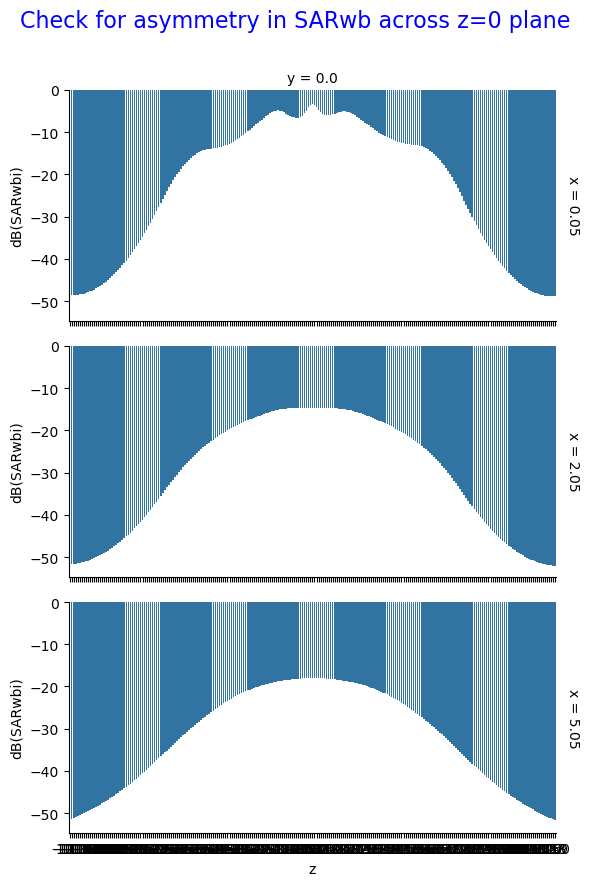

In [44]:
# Bar plots of dB(SARwb) along z for various values of x and y
SARdfi = SARdfi_xz.copy()
SARdfi['dB(SARwbi)'] = dB(SARdfi.SARwbi)
xvals = [0.05,2.05,5.05]
yvals = [0]

mask = (SARdfi.x.isin(xvals)) & (SARdfi.y.isin(yvals))
g = sn.FacetGrid(SARdfi[mask], col="y", row="x",margin_titles=True,
                 height=3, aspect=2)
g.map(sn.barplot, 'z', "dB(SARwbi)", order=np.sort(SARdfi_xz.z.unique()))

plt.suptitle(f"Check for asymmetry in SARwb across z=0 plane\n",fontsize=16,c='b')
plt.tight_layout();

Data looks nicely symmetric in the z axis, except very close to the antenna. It is *not* expected to be perfectly symmetric since the body phantom is not totally symmetric in the z direction

### Merge Sall and SARdfi_xyz with S
*Don't* merge in **SARdfall** since some of the SARwb points, e.g. y=0.36, x=0.81, are not on the 0.1m grid spacing

In [45]:
# Create Sall by merging SARwb and SARps from SARdf with S dataframe
Sall = S.merge(SARdfi_xz,how='left',on=['x','y','z']).sort_values(['x','y','z'],ignore_index=True)
Sall.head()

,x,y,z,SE,SH,Smax,SARwbi
0,0.05,0.0,-12.0,0.000485,6.529958e-07,0.000485,0.000014
1,0.05,0.0,-11.9,0.000512,6.884640e-07,0.000512,0.000014
2,0.05,0.0,-11.8,0.000540,7.264836e-07,0.000540,0.000014
3,0.05,0.0,-11.7,0.000570,7.672851e-07,0.000570,0.000014
4,0.05,0.0,-11.6,0.000603,8.111243e-07,0.000603,0.000014


In [46]:
# showgridpoints(Sall,t.fMHz,fields=['SARwbi','Smax'], axv=(True,True,False),antcolor='yellow')

### Compare histogram of Danie's SARwb values with my log-quadratic interpolated values (SARwbi)

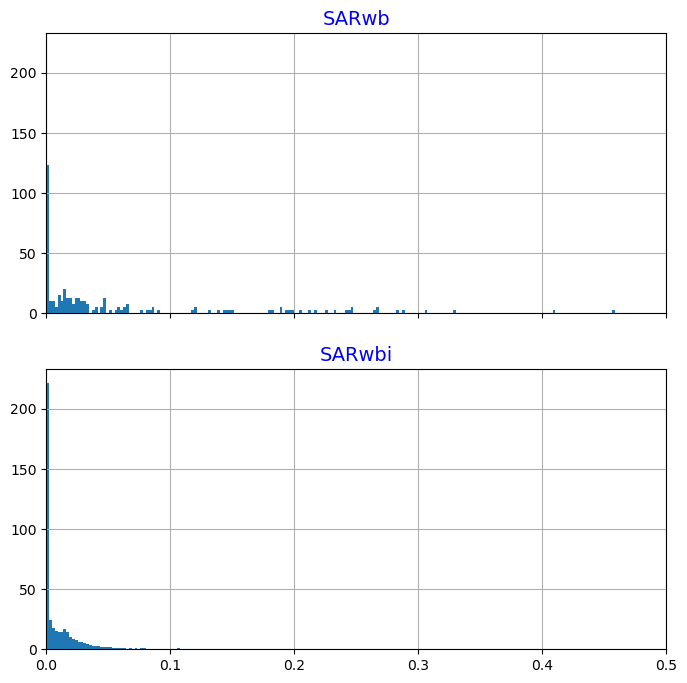

In [47]:
fig, ax = plt.subplots(2,1,sharex=True,sharey=True,figsize=(8, 8))
bins = 200
SARdf0.SARwb.hist(bins=bins,ax=ax[0],density=True)
Sall.SARwbi.hist(bins=bins,ax=ax[1],density=True)
ax[0].set_title('SARwb',fontsize=14,color='b')
ax[1].set_title('SARwbi',fontsize=14,color='b');
plt.xlim(0,0.5);

Danie's SAR data and my interpolated data have similar histogram distributions

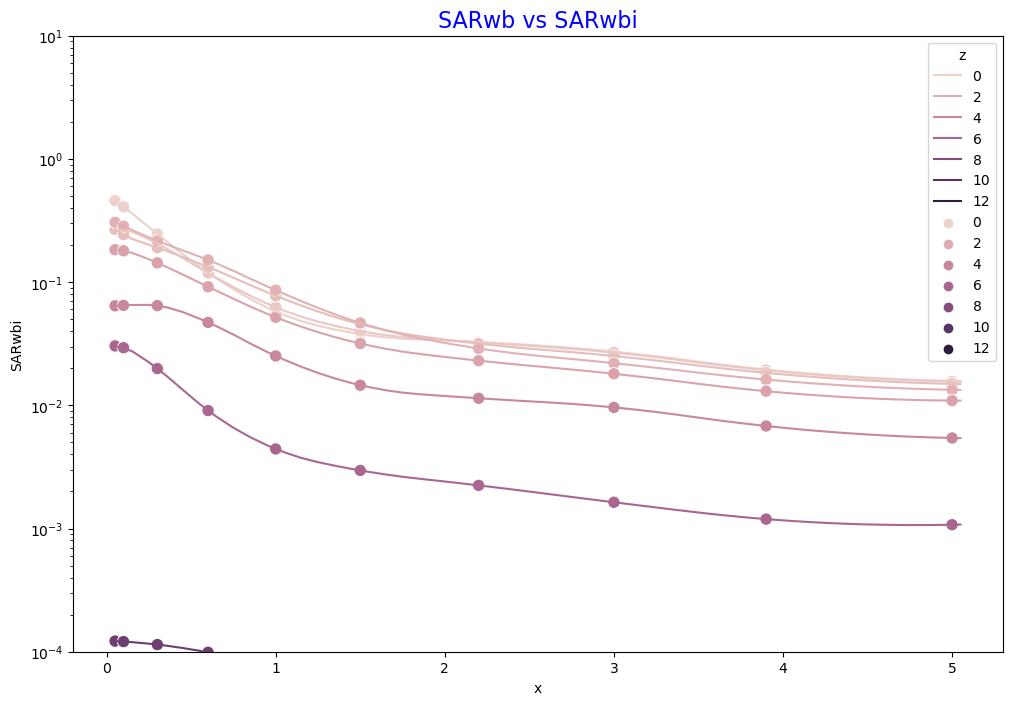

In [48]:
# Line plots of SARwb and SARwbi
fig, ax = plt.subplots(figsize=(12, 8))
y = 0
zset = set(Sall.z.unique()) & set(SARdf0.z.unique())
z = [zi for zi in zset if zi >= 0]
mask1 = (Sall.y == y) & (Sall.z.isin(z))
mask2 = (SARdf0.y == y) & (SARdf0.z.isin(z))
sn.lineplot(data=Sall[mask1],x='x',y='SARwbi',hue='z')
sn.scatterplot(data=SARdf0[mask2],x='x',y='SARwb',hue='z',s=80)
ax.set_yscale('log')
ax.set_ylim(top=10,bottom=0.0001)
ax.set_title('SARwb vs SARwbi', fontsize=16, color='b')
fig.savefig('../antennas/HYagi/plots/hyagi interpolation check.png',dpi=150)

Danie's SAR points (`SARwb`) all lie on the lines for my log-linear interpolated data (`SARwbi`)

## Calculate spatial averages

In [49]:
# 1.6m vertical average curves
l, dl = 1.6, 0.1
m = 5
c = conv_vector(l, dl, m)
print(f'\n{m:2d} points: sum{list(c.round(3))} = {sum(c)}')
sa, name, title = spatavg(Sall, f"Smax-{l}m-{m}",  "Smax",  c, 
                          title=f"FEKO Smax levels ({m} points averaged over {l}m)")
Sall[name] = sa


 5 points: sum[0.2, 0.0, 0.0, 0.0, 0.2, 0.0, 0.0, 0.0, 0.2, 0.0, 0.0, 0.0, 0.2, 0.0, 0.0, 0.0, 0.2] = 1.0
creating Smax-1.6m-5 spatial average of Smax


In [50]:
# 1.6m vertical average curves using Simpsons 1/3 rule
l = 1.6
c17 = [1,4,2,4,2,4,2,4,2,4,2,4,2,4,2,4,1]
c5  = [1,0,0,0,4,0,0,0,2,0,0,0,4,0,0,0,1]
c3  = [1,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,1]
for m,clist in zip([5,17],[c5,c17]):
    dl = l / (m-1)
    c = (1/3)*(dl/l) * np.array(clist)
    print(f'\n{m:2d} points: sum{list(c.round(3))} = {sum(c)}')
    sa, name, title = spatavg(Sall, f"SE-{l}m-{m}-S13", "SE", c, 
                              title=f"FEKO SE levels ({m} points averaged over {l}m (Simpson 1/3))")
    Sall[name] = sa
    sa, name, title = spatavg(Sall, f"Smax-{l}m-{m}-S13", "Smax",  c, 
                              title=f"FEKO Smax levels ({m} points averaged over {l}m (Simpson 1/3))")
    Sall[name] = sa


 5 points: sum[0.083, 0.0, 0.0, 0.0, 0.333, 0.0, 0.0, 0.0, 0.167, 0.0, 0.0, 0.0, 0.333, 0.0, 0.0, 0.0, 0.083] = 0.9999999999999999
creating SE-1.6m-5-S13 spatial average of SE
creating Smax-1.6m-5-S13 spatial average of Smax

17 points: sum[0.021, 0.083, 0.042, 0.083, 0.042, 0.083, 0.042, 0.083, 0.042, 0.083, 0.042, 0.083, 0.042, 0.083, 0.042, 0.083, 0.021] = 1.0
creating SE-1.6m-17-S13 spatial average of SE
creating Smax-1.6m-17-S13 spatial average of Smax


In [51]:
Sall

,x,y,z,SE,SH,Smax,SARwbi,Smax-1.6m-5,SE-1.6m-5-S13,Smax-1.6m-5-S13,SE-1.6m-17-S13,Smax-1.6m-17-S13
0,0.05,0.0,-12.0,0.000485,6.529958e-07,0.000485,0.000014,0.000370,0.000345,0.000345,0.000315,0.000315
1,0.05,0.0,-11.9,0.000512,6.884640e-07,0.000512,0.000014,0.000391,0.000365,0.000365,0.000374,0.000374
2,0.05,0.0,-11.8,0.000540,7.264836e-07,0.000540,0.000014,0.000415,0.000387,0.000387,0.000416,0.000416
3,0.05,0.0,-11.7,0.000570,7.672851e-07,0.000570,0.000014,0.000440,0.000410,0.000410,0.000481,0.000481
4,0.05,0.0,-11.6,0.000603,8.111243e-07,0.000603,0.000014,0.000565,0.000597,0.000597,0.000530,0.000530
...,...,...,...,...,...,...,...,...,...,...,...,...
12286,5.05,0.0,11.6,0.000401,3.941729e-04,0.000401,0.000008,0.000343,0.000379,0.000384,0.000323,0.000325
12287,5.05,0.0,11.7,0.000397,3.963695e-04,0.000397,0.000008,0.000257,0.000245,0.000245,0.000301,0.000304
12288,5.05,0.0,11.8,0.000393,3.985574e-04,0.000399,0.000008,0.000253,0.000241,0.000242,0.000265,0.000267
12289,5.05,0.0,11.9,0.000389,4.006796e-04,0.000401,0.000007,0.000249,0.000237,0.000239,0.000245,0.000247


## Draw plots

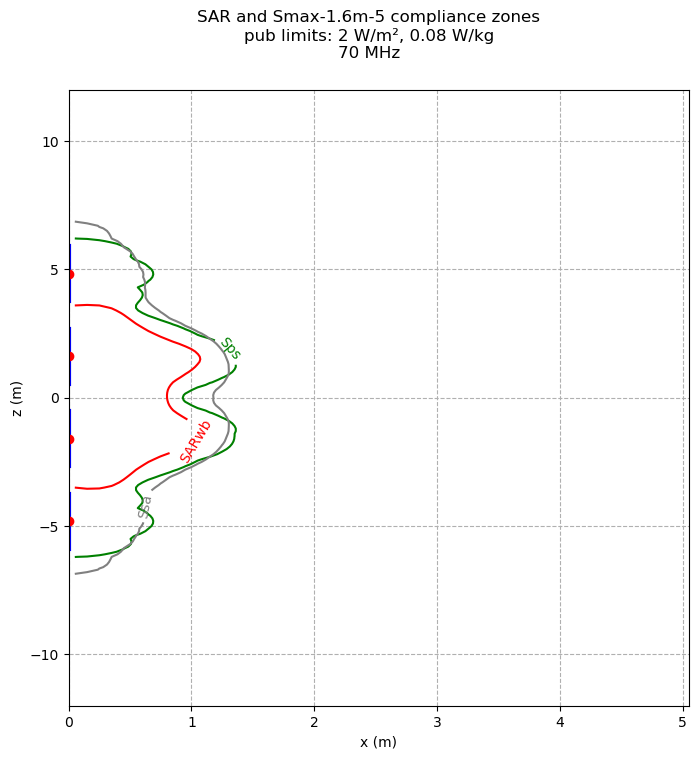

In [52]:
# Plot compliance boundaries
complot(Sall,t.fMHz,'pub',S='Smax-1.6m-5');

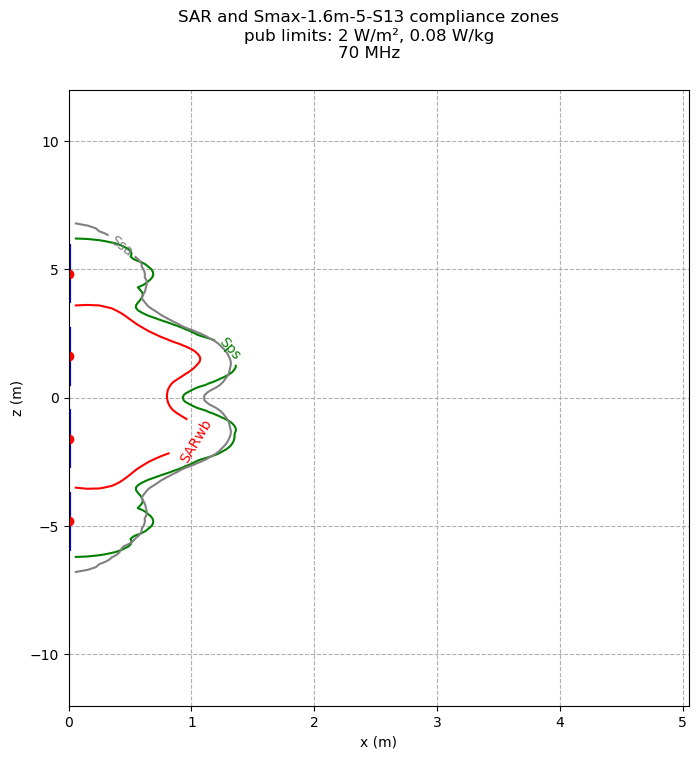

In [53]:
# Plot compliance boundaries
complot(Sall,t.fMHz,'pub',S='Smax-1.6m-5-S13');

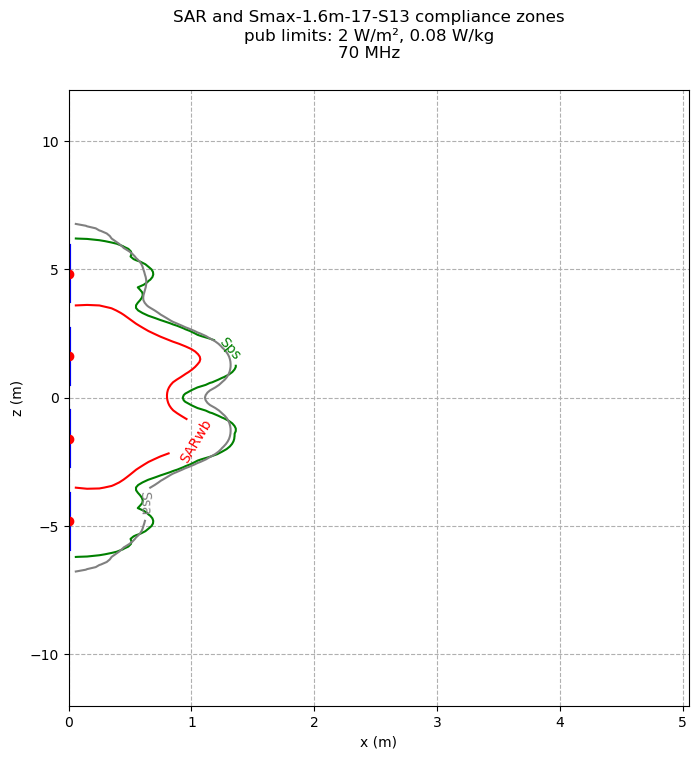

In [54]:
# Plot compliance boundaries
complot(Sall,t.fMHz,'pub',S='Smax-1.6m-17-S13');

## Check SARwb values

,x,y,z,SE,SH,Smax,SARwbi,Smax-1.6m-5,SE-1.6m-5-S13,Smax-1.6m-5-S13,SE-1.6m-17-S13,Smax-1.6m-17-S13
2371,4.65,0.0,0.0,1.955861,1.967818,1.967818,0.012450,1.478284,1.611210,1.618630,1.610102,1.617509
2422,4.75,0.0,0.0,1.876936,1.888053,1.888053,0.011991,1.432978,1.557251,1.564302,1.556215,1.563253
2473,4.85,0.0,0.0,1.802638,1.812992,1.812992,0.011553,1.389489,1.505750,1.512453,1.504784,1.511475
2524,4.95,0.0,0.0,1.732616,1.742276,1.742276,0.011135,1.347733,1.456574,1.462948,1.455675,1.462038
2575,5.05,0.0,0.0,1.666553,1.675580,1.675580,0.010737,1.307633,1.409597,1.415662,1.408761,1.414816


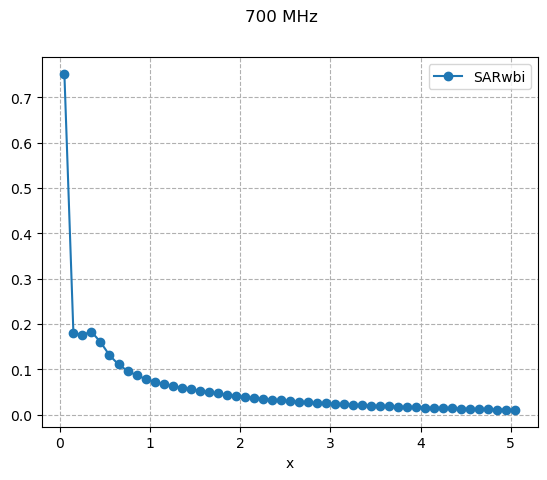

In [29]:
# Get SARwb values along x axis, i.e. z=0
df0 = Sall.query("z==0")
fig,ax = plt.subplots()
df0.plot('x','SARwbi',marker='o',ax=ax)
fig.suptitle(f'{t.fMHz} MHz')
plt.grid(ls='--')
df0.tail()

In [68]:
# Check SARwbi values against Dimbylow value
SARdimb = 19.84E-6
Edimb = 1
df0 = Sall.query("z==0 & x==4.05")
display(df0)
SARwbi = df0['SARwbi'].values[0]
S = df0['SE-1.6m-5-S13'].values[0]
E = np.sqrt(377*S)
SARwbi_scaled = SARwbi * (Edimb / E)**2
print(f'SAR Dimbylow = {SARdimb*1E6} µW/kg, scaled FEKO SARwbi = {SARwbi_scaled*1E6} µW/kg')

,x,y,z,SE,SH,Smax,SARwbi,Smax-1.6m-5,SE-1.6m-5-S13,Smax-1.6m-5-S13,SE-1.6m-17-S13,Smax-1.6m-17-S13
1660,4.05,0.0,0.0,2.608815,2.620513,2.620513,0.016698,1.81296,2.025509,2.032145,2.023997,2.030571


SAR Dimbylow = 19.84 µW/kg, scaled FEKO SARwbi = 21.8675970312732 µW/kg


In [83]:
# IEC 62232 (2018) SAR formula values
d = 4     # m
body = 'adult'
fMHz = 1000  # MHz
P = 100      # W
N = 4 
DdBi = 7.38
L = 9.166    # m
Φdeg = 360   # horizontal HPBW in degrees
Θdeg = 20.3  # vertical HPBW in degress
SARwbIEC, SAR10g, SAR1g = SAR_IEC_front(d,body,fMHz,P,N,DdBi,L,Φdeg,Θdeg)
print(SARwbIEC)

0.0039013634476601135


,x,y,z,SE,SH,Smax,SARwbi,Smax-1.6m-5,SE-1.6m-5-S13,Smax-1.6m-5-S13,SE-1.6m-17-S13,Smax-1.6m-17-S13,SARwbIEC,ratio
36,3.65,0.0,0.0,3.196541,3.213086,3.213086,0.019746,2.078066,2.361953,2.370351,2.360752,2.368950,0.004284,4.609138
37,3.75,0.0,0.0,3.032434,3.047544,3.047544,0.018932,2.007376,2.271333,2.279249,2.269953,2.277648,0.004167,4.542752
38,3.85,0.0,0.0,2.880535,2.894373,2.894373,0.018153,1.939731,2.185212,2.192675,2.183736,2.191031,0.004057,4.474819
39,3.95,0.0,0.0,2.739674,2.752381,2.752381,0.017410,1.874974,2.103349,2.110384,2.101834,2.108759,0.003952,4.405596
40,4.05,0.0,0.0,2.608815,2.620513,2.620513,0.016698,1.812960,2.025509,2.032145,2.023997,2.030571,0.003852,4.335323


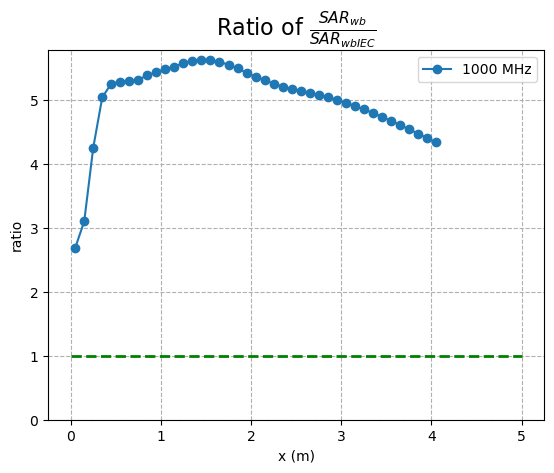

In [78]:
# IEC 62232 2018 validation values
df0 = Sall.query("z==0")
dlist = df0.x.values
body = 'adult'
fMHz = t.fMHz  # MHz
P = t.Prad     # W
N = 4
DdBi = t.dBiGain
L = omni_length(fMHz)  # m
Φdeg = 360  # t.horizHPBW   # horizontal HPBW in degrees
Θdeg = t.vertHPBW    # vertical HPBW in degress

if fMHz >= 300:
    IECdatalist = [[d, SAR_IEC_front(d,body,fMHz,P,N,DdBi,L,Φdeg,Θdeg)[0]] for d in dlist]
    dfIEC = pd.DataFrame(IECdatalist,columns=('x','SARwbIEC'))
    dfIEC = pd.merge(df0,dfIEC,on='x')
    dfIEC['ratio'] = dfIEC.SARwbi / dfIEC.SARwbIEC
    display(dfIEC.tail())

    fig,ax = plt.subplots()
    dfIEC.plot('x','ratio',ax=ax,marker='o',label=f'{t.fMHz} MHz')
    ax.grid(ls='--')
    ax.set_title(r'Ratio of $\frac{SAR_{wb}}{SAR_{wbIEC}}$',fontsize=16)
    ax.set_ylim(0)
    ax.set_xlabel('x (m)')
    ax.set_ylabel('ratio')
    ax.hlines(1, 0, 5, lw=2, ls='--', color='g')
    fig.savefig('SAR compare 400 MHz.png')

In [11]:
# Check S value in far(ish) field at z=0, x=5.05
d = S.x.max()

Smax1 = S[(S.z==0) & (S.x==d)]
display(Smax1)

G = 10**(DdBi/10)
Scalc = P * G / (4 * np.pi * d**2)
Scalc


,x,y,z,SE,SH,Smax
1660,4.05,0.0,0.0,2.608815,2.620513,2.620513


2.653872715889297

## Scratch

### Create dummy data

In [29]:
def radiator(x0, y0, X, Y, PG):
    '''Calculate S for isotropic radiator on located at x0, y0
       on X, Y meshgrid for PG=power*gain'''
    r2 = (X-x0)**2 + (Y-y0)**2
    rsmall = X[0,1] - X[0,0]
    r2[r2==0] = (rsmall/4)**2  #Set small non zero value for r2 at r2 = 0
    S = PG / (4*np.pi*r2)
    return S

In [30]:
PG = 10
delta = 0.1
x = np.arange(0, 6+delta, delta)
y = np.arange(-3.0, 3.0+delta, delta) 
X, Y = np.meshgrid(x, y)
S1 = radiator(0,-1,X,Y,PG)
S2 = radiator(0,0,X,Y,PG)
S3 = radiator(0,1,X,Y,PG)
S = S1 + S2 + S3
SAR = S/2

In [6]:
import numpy as np
fMHz = 400
S = RFcalcUC.Slimit(fMHz, setting='pub', standard='RPS S-1 WB')
g = 7.4
G = 10 ** (g/10)
P = 100
d = np.sqrt(P * G /(4 * np.pi * S))
ic(S,d)

ic| S: 2, d: 4.676059946832393


(2, 4.676059946832393)

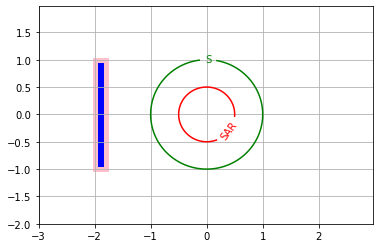

In [13]:
# Made up data for testing plots
delta = 0.025
x = np.arange(-3.0, 3.0, delta)
y = np.arange(-2.0, 2.0, delta) 
X, Y = np.meshgrid(x, y)
Z1 = np.sqrt(X**2 + Y**2)
Z2 = 2 * np.sqrt(X**2 + Y**2)

# Create figure
fig1, ax1 = plt.subplots()

# Basic contour plots for two sets of data
limit = 1
CS1 = ax1.contour(X, Y, Z1, levels=[limit], colors=['green'])
CS2 = ax1.contour(X, Y, Z2, levels=[limit], colors=['red'])
ax1.grid()

# Add named contour lables at Z=1 for each data set
fmt1 = {limit:'S'}
fmt2 = {limit:'SAR'}

# Label every other level using strings
ax1.clabel(CS1, CS1.levels, inline=True, fmt=fmt1, fontsize=10)
ax1.clabel(CS2, CS2.levels, inline=True, fmt=fmt2, fontsize=10)

# Add antenna box
ax1.add_patch(Rectangle((-2, -1), 0.2, 2,
              edgecolor = 'pink',
              facecolor = 'blue',
              fill=True,
              lw=5))

#add rectangle to plot
# ax.add_patch(Rectangle((1, 1), 2, 6,
#              edgecolor = 'pink',
#              facecolor = 'blue',
#              fill=True,
#              lw=5))


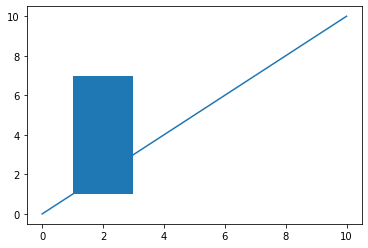

In [3]:
from matplotlib.patches import Rectangle

#define Matplotlib figure and axis
fig, ax = plt.subplots()

#create simple line plot
ax.plot([0, 10],[0, 10])

#add rectangle to plot
ax.add_patch(Rectangle((1, 1), 2, 6))
